# <div style="color:white;display:fill;border-radius:5px;background-color:#2F4F4F;letter-spacing:0.5px;overflow:hidden\"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%\">Hackday 8</h1></div>

# 0.0 Imports

In [1]:
import pandas as pd
from IPython.display import Image
import os
from dotenv import load_dotenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import inflection
from ydata_profiling import ProfileReport
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, train_test_split
import optuna
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA


## 0.1 Settings

In [2]:
#remove warnings
warnings.filterwarnings('ignore')

In [3]:
def pandas_settings():
    pd.options.display.float_format = '{:,.4f}'.format
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False )

pandas_settings()

In [4]:
def plot_settings():

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rc('animation', html='html5')
    plt.rc('axes',titlesize=18)
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    sns.set(style='whitegrid')

plot_settings()

## 0.2 Helper Functions

In [5]:
def countplot(x, df, order=True, size=(8, 5)):
    """
    Função que plota a contagem de uma certa variável x em um dataframe.
    """
    plt.figure(figsize=size)
    if order == True:
        ax = sns.countplot(x=x, data=df, order=df[x].value_counts().index, palette='Blues_r')
    else:
        ax = sns.countplot(x=x, data=df, color = 'steelblue')
    plt.xlabel(x, fontsize=14)
    plt.ylabel('')
    plt.xticks(fontsize=12)
    # Adiciona o título
    plt.title(f'{x}', fontsize=18)
    for bar in ax.patches:
        ax.annotate(format(bar.get_height()),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                        size=12, xytext=(0, 6),
                        textcoords='offset points',
                        color='#092532')
    ax.get_yaxis().set_visible(False)
    sns.despine(left=True, bottom=True);


def numerical_metrics(num_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(num_attributes.apply(np.std)).T
    d_min = pd.DataFrame(num_attributes.apply(min)).T
    d_max = pd.DataFrame(num_attributes.apply(max)).T
    d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    q1_ = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x,25))).T
    q3_ = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x,75))).T
    d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    #concat
    num_desc = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,q1_,q3_, d_skew,d_kurtosis]).T.reset_index()
    num_desc.columns=['attributes','min','max','range','mean','median','std','25%','75%','skew','kurtosis']

    return num_desc

## 0.3 Loading Data

### 0.3.1 Postgres

In [6]:
# # Carregar variáveis de ambiente
# load_dotenv()

# # Cria a conexão com o banco de dados usando SQLAlchemy
# engine = create_engine(f'postgresql://{os.getenv("DB_USER")}:{os.getenv("DB_PASSWORD")}@{os.getenv("DB_HOST")}:{os.getenv("DB_PORT")}/{os.getenv("DB_NAME")}')


# # Lista de tabelas para coletar
# table_names = ["tb_falta_higiene", "tb_conscientizacao", "tb_agua_parada", "tb_casos_dengue", "tb_condicoes_climaticas", "tb_fato"]

# # Dicionário para armazenar os DataFrames
# dataframes = {}

# for table in table_names:
#     # Consulta para obter todos os dados da tabela|
#     query = f"SELECT * FROM {table}"

#     # Executa a consulta e armazena os resultados em um DataFrame
#     dataframes[table] = pd.read_sql_query(query, engine)

# # Fechar a conexão
# engine.dispose()

In [7]:
# # salvar tabelas localmente
# for table_name, df in dataframes.items():
#     df.to_csv(f'/data/{table_name}.csv', index=False)

### 0.3.2 Local

In [8]:
df_falta_higiene = pd.read_csv('data/tb_falta_higiene.csv')
df_conscientizacao = pd.read_csv('data/tb_conscientizacao.csv')
df_agua_parada = pd.read_csv('data/tb_agua_parada.csv')
df_casos_dengue = pd.read_csv('data/tb_casos_dengue.csv')
df_condicoes_climaticas = pd.read_csv('data/tb_condicoes_climaticas.csv')
df_fato = dataframes = pd.read_csv('data/tb_fato.csv')

In [9]:
#altera nome coluna id para conscientização da população
df_conscientizacao.rename(columns={'id':'Conscientização da População'},inplace=True)

df_raw = pd.merge(df_fato,df_conscientizacao,how='left',on='Conscientização da População')
df_raw = pd.merge(df_raw,df_agua_parada,how='left',on='Date')
df_raw = pd.merge(df_raw,df_falta_higiene,how='left',on='Date')
df_raw = pd.merge(df_raw,df_condicoes_climaticas,how='left',on='Date')
df_raw = pd.merge(df_raw,df_casos_dengue,how='left',on='Date')

In [10]:
# check dados duplicados e retorno valor booleano
print('Existem dados duplicados?',df_raw.duplicated().any())

Existem dados duplicados? False


In [11]:
#drop duplicates
# df_raw = df_raw.drop_duplicates()

## 0.4 Split train / test

In [12]:
# test
df_test = df_raw[df_raw['Casos de dengue'].isnull()]
df_test = df_test.drop(columns=['Casos de dengue'])

# train
df_train = df_raw.dropna(subset=['Casos de dengue'])

# 1.0 Data Description

In [13]:
df1 = df_train.copy()

## 1.1 Data Dimension

In [14]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 12014
Number of Columns: 21


## 1.2 Check types

In [15]:
df1.dtypes

Date                                           object
Conscientização da População                    int64
Condições de Moradia Precárias                 object
Falta de Acesso a Serviços de Saúde            object
Migração de Pessoas de Áreas Endêmicas         object
Transporte de Mercadorias em Áreas Urbanas     object
Outros                                         object
Presença do mosquito                           object
status                                         object
Presença de Criadouros                         object
Água Parada em Terrenos Baldios                object
Presença de Piscinas sem Manutenção            object
Presença de Recipientes sem Tampas             object
Falta de Coleta de Lixo                        object
Áreas com Acúmulo de Entulhos                  object
Falta de Controle de Pragas                    object
Taxa de Tratamento de Esgoto                   object
Precipitação                                   object
Umidade                     

## 1.3 Check NA

In [16]:
df1.isna().sum()

Date                                           0
Conscientização da População                   0
Condições de Moradia Precárias                62
Falta de Acesso a Serviços de Saúde           91
Migração de Pessoas de Áreas Endêmicas        69
Transporte de Mercadorias em Áreas Urbanas    63
Outros                                        56
Presença do mosquito                          53
status                                         0
Presença de Criadouros                        74
Água Parada em Terrenos Baldios               68
Presença de Piscinas sem Manutenção           59
Presença de Recipientes sem Tampas            67
Falta de Coleta de Lixo                       59
Áreas com Acúmulo de Entulhos                 56
Falta de Controle de Pragas                   69
Taxa de Tratamento de Esgoto                  65
Precipitação                                  53
Umidade                                       65
Temperatura                                   54
Casos de dengue     

A seguir, vamos verificar se existem mais valores inconsistentes e que deveriam ser considerados nulos.

Para isso, vamos filtrar todos os valores que não contém os seguintes caracteres: ```-```, ```,``` ou ```.```.

In [17]:
def check_values(df):
    # Converte para str
    df = df.astype(str)

    for col in df:
        print(col)
        # Filtra os valores que NÃO contêm a vírgula
        df_filtrado = df[~df[col].str.contains('[,.-]', na=False)]

        # Lista de valores únicos de cada variável
        lista_exemplo = df_filtrado[col].sort_values().unique().tolist()

        # Lista para armazenar os valores que são alfabéticos ou ASCII
        resultados = []

        for item in lista_exemplo:
            # Verifica se o item é uma instância de str para ser considerado para ASCII ou alfabético
            if isinstance(item, str):
                # Verifica se todos os caracteres são alfabéticos
                if item.isalpha():
                    resultados.append(item)
                else:
                    # Verifica se o item é ASCII
                    if all(ord(char) < 128 for char in item) and not item.isnumeric():
                        resultados.append(item)

        # Exibindo os resultados
        print(resultados)
        print()

In [18]:
df_raw_not_null = df_raw.copy()
check_values(df_raw_not_null)

Date
[]

Conscientização da População
[]

Condições de Moradia Precárias
['indisponivel', 'nan']

Falta de Acesso a Serviços de Saúde
['indisponivel', 'nan']

Migração de Pessoas de Áreas Endêmicas
['indisponivel', 'nan']

Transporte de Mercadorias em Áreas Urbanas
['indisponivel', 'nan']

Outros
['indisponivel', 'nan']

Presença do mosquito
['indisponivel', 'nan']

status
['<>', 'conscientizada', 'desconscientizada', 'indisponivel', 'parcialmente conscientizada']

Presença de Criadouros
['indisponivel', 'nan']

Água Parada em Terrenos Baldios
['indisponivel', 'nan']

Presença de Piscinas sem Manutenção
['indisponivel', 'nan']

Presença de Recipientes sem Tampas
['indisponivel', 'nan']

Falta de Coleta de Lixo
['indisponivel', 'nan']

Áreas com Acúmulo de Entulhos
['indisponivel', 'nan']

Falta de Controle de Pragas
['indisponivel', 'nan']

Taxa de Tratamento de Esgoto
['indisponivel', 'nan']

Precipitação
['indisponivel', 'nan']

Umidade
['indisponivel', 'nan']

Temperatura
['indispon

## 1.4 Data Clean

In [19]:
def replace_nan(df, inconsistencias):
    """
    Esta função substitui os valores especificados em uma lista chamada
    valores_substituir por NaN em todas as colunas do DataFrame.
    """
    for coluna in df.columns:
        df[coluna] = df[coluna].apply(lambda x: np.nan if x in inconsistencias else x)

    return df

def change_types(df):
    """Funcao para alterar os tipos das colunas do dataframe"""

    # alterar tipo data
    df['date'] = pd.to_datetime(df['date'])


    cols_float = ['condicoes_de_moradia_precarias', 'falta_de_acesso_a_servicos_de_saude',
       'migracao_de_pessoas_de_areas_endemicas',
       'transporte_de_mercadorias_em_areas_urbanas', 'outros',
       'presenca_de_criadouros','agua_parada_em_terrenos_baldios',
       'falta_de_coleta_de_lixo','areas_com_acumulo_de_entulhos', 'falta_de_controle_de_pragas',
       'taxa_de_tratamento_de_esgoto', 'precipitacao', 'umidade',
       'temperatura']
    # alterar colunas para float
    df[cols_float] = df[cols_float].apply(lambda x: x.str.replace(',','.').str.replace(' ',''))
    df[cols_float] = df[cols_float].astype(float)

    # alterar coluna para int
    cols_int = ['conscientizacao_da_populacao', 'presenca_do_mosquito', 'presenca_de_piscinas_sem_manutencao', 'presenca_de_recipientes_sem_tampas']
    df[cols_int] = df[cols_int].astype('Int64')

    df.sort_values('date',inplace=True)

    return df


def data_clean(df, is_train):

    """Funcao para limpeza dos dados"""

    inconsistencias = ['', 'indisponivel', '<>']

    #underscore
    cols_old = df.columns.tolist()
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new

    #retirar acentos
    df.columns = [inflection.transliterate(column) for column in df.columns]

    # inserir underline entre palavras
    df.columns = [column.replace(' ', '_') for column in df.columns]

    #subistituir linhas com valor indisponivel por nan
    df = replace_nan(df, inconsistencias)

    # alterar tipos
    df = change_types(df)

    # se is_train for True, alterar a variável alvo para Int64
    if is_train:
        df['casos_de_dengue'] = df['casos_de_dengue'].replace(",", "")
        df['casos_de_dengue'] = df['casos_de_dengue'].replace(".", "")
        df['casos_de_dengue'] = df['casos_de_dengue'].astype(int)

    return df

In [20]:
df1 = data_clean(df1, is_train=True)

In [21]:
df1.isna().sum()

date                                            0
conscientizacao_da_populacao                    0
condicoes_de_moradia_precarias                122
falta_de_acesso_a_servicos_de_saude           156
migracao_de_pessoas_de_areas_endemicas        132
transporte_de_mercadorias_em_areas_urbanas    132
outros                                        119
presenca_do_mosquito                          112
status                                        123
presenca_de_criadouros                        119
agua_parada_em_terrenos_baldios               134
presenca_de_piscinas_sem_manutencao           112
presenca_de_recipientes_sem_tampas            131
falta_de_coleta_de_lixo                       122
areas_com_acumulo_de_entulhos                 108
falta_de_controle_de_pragas                   123
taxa_de_tratamento_de_esgoto                  137
precipitacao                                  122
umidade                                       131
temperatura                                   127


## 1.5 Fill NA

A estratégia para remoção dos valores ausentes foi substituir valores numéricos pela média e os valores categóricos pela moda.

In [22]:
def fill_na(df):
    # substituir colunas tipo float pela media
    float_columns = df.select_dtypes(include=['float64']).columns

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].mean())

    # alterar colunas inteiras para a media
    int_columns = df.select_dtypes(include=['Int64']).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(round(df[col].mean())).astype(int)

    # alterar colunas categoricas para a moda
    object_columns = df.select_dtypes(include=['object']).columns

    for col in object_columns:
        df[col] = df[col].fillna(df[col].mode()[0])


    return df

In [23]:
# Cria um dataframe auxiliar que será utilizado na EDA
df_raw2 = df1.copy()


df1 = fill_na(df1)

## 1.6 Data Descriptive

In [24]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.6.1 Numerical attributes

Analisando a descrição dos dados, notamos um range muito distante da média e mediana nas variáveis presenca_do_mosquito e na variavel target (casos_de_dengue) , veremos mais adiante se há presença de outliers que podem prejudicar o desempenho de nosso modelo.

In [25]:
numerical_metrics(num_attributes)

,attributes,min,max,range,mean,median,std,25%,75%,skew,kurtosis
0,conscientizacao_da_populacao,1.0000,5.0000,4.0000,2.0323,2.0000,0.6806,2.0000,2.0000,0.4637,1.1482
1,condicoes_de_moradia_precarias,0.1000,0.6999,0.5999,0.4025,0.4025,0.1731,0.2524,0.5548,-0.0202,-1.1975
2,falta_de_acesso_a_servicos_de_saude,0.0500,0.4999,0.4499,0.2742,0.2742,0.1290,0.1637,0.3858,0.0104,-1.1770
3,migracao_de_pessoas_de_areas_endemicas,0.1001,0.8000,0.6998,0.4540,0.4540,0.2023,0.2794,0.6312,-0.0420,-1.1926
4,transporte_de_mercadorias_em_areas_urbanas,0.0500,0.6000,0.5500,0.3211,0.3211,0.1569,0.1846,0.4568,0.0202,-1.1807
5,outros,0.0500,0.6000,0.5500,0.3272,0.3272,0.1567,0.1922,0.4616,-0.0148,-1.1764
6,presenca_do_mosquito,"1,023.0000","999,530.0000","998,507.0000","284,476.5390","202,469.0000","266,167.3860","64,312.7500","438,702.5000",0.9913,-0.0229
7,presenca_de_criadouros,0.1003,0.8000,0.6997,0.4482,0.4482,0.2004,0.2753,0.6216,0.0039,-1.1791
8,agua_parada_em_terrenos_baldios,0.1000,0.6999,0.5999,0.3988,0.3988,0.1720,0.2509,0.5471,0.0150,-1.1785
9,presenca_de_piscinas_sem_manutencao,200.0000,"4,999.0000","4,799.0000","2,586.7626","2,587.0000","1,377.6172","1,401.2500","3,771.7500",0.0073,-1.1826


### 1.6.2 Categorical attributes

In [26]:
cat_attributes.describe()

,status
count,12014
unique,3
top,parcialmente conscientizada
freq,7253


# 2.0 Feature Engeneering

In [27]:
df2  = df1.copy()

In [28]:
# indice de temperatura e umidade
def calcular_ITU(temperatura, umidade):
    """ Função para calcular o índice de temperatura e umidade"""
    return -2.653 + (0.994 + temperatura) + (0.0153 * umidade)

# indice de calor
def calcular_indice_calor(temperatura, umidade):
    """ Função para calcular o índice de calor"""
    return -8.78469475556 + (1.61139411 * temperatura) + (2.33854883889 * umidade) + (-0.14611605 * temperatura * umidade) + (-0.012308094 * temperatura ** 2) + (-0.0164248277778 * umidade ** 2) + (0.002211732 * temperatura ** 2 * umidade) + (0.00072546 * temperatura * umidade ** 2) + (-0.000003582 * temperatura ** 2 * umidade ** 2)

def feature_engineering(df):
    """ Função para realizar a engenharia de features"""
    # sazonaliade
    df['estacao_ano'] = df['date'].dt.month.apply(lambda x: 'verao' if x in [1,2,12] else 'outono' if x in [3,4,5] else 'inverno' if x in [6,7,8] else 'primavera')
    df['semana_ano'] = df['date'].dt.isocalendar().week.astype(int)
    df['ano'] = df['date'].dt.year
    df['mes'] = df['date'].dt.month
    df['dia'] = df['date'].dt.day

    # criar nova coluna ITU
    df['itu'] = calcular_ITU(df['temperatura'], df['umidade'])

    dados_combinados = df[['precipitacao', 'umidade', 'temperatura']]

    # padronizar os dados
    scaler = StandardScaler()
    dados_padronizados = scaler.fit_transform(dados_combinados)

    # PCA para reduzir a dimensionalidade
    pca = PCA(n_components=1)
    componente_principal = pca.fit_transform(dados_padronizados)

    df['pca_clima'] = componente_principal

    return df


In [29]:
df2 = feature_engineering(df2)

# 3.0 EDA (Exploratory Data Analysis)

In [30]:
df3 = df2.copy()

##  3.1 Univariate Analysis

### 3.1.1 Target variable

- Podemos observar uma grande quantidade de valores extremos(outliers) presentes em nossa variável resposta.

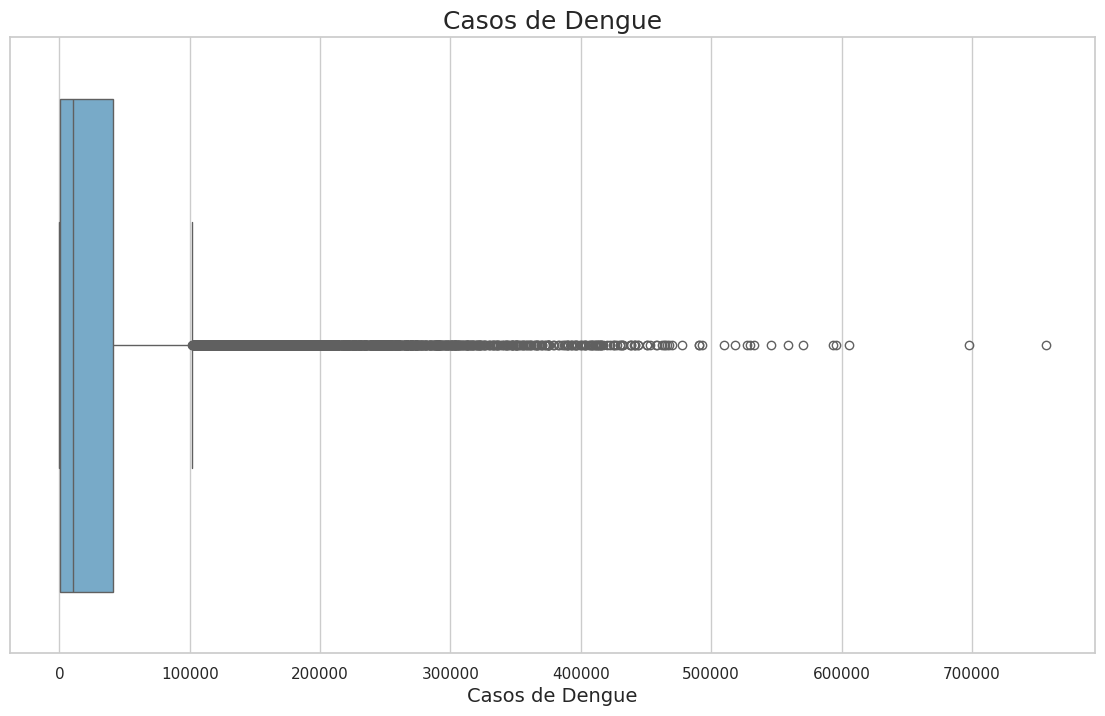

In [31]:
#boxplot casos de dengue
plt.figure(figsize=(14, 8))
sns.boxplot(x='casos_de_dengue', data=df3, palette='Blues')
plt.title('Casos de Dengue', fontsize=18)
plt.xlabel('Casos de Dengue', fontsize=14)
plt.show()


### 3.1.2 Numerical attibutes

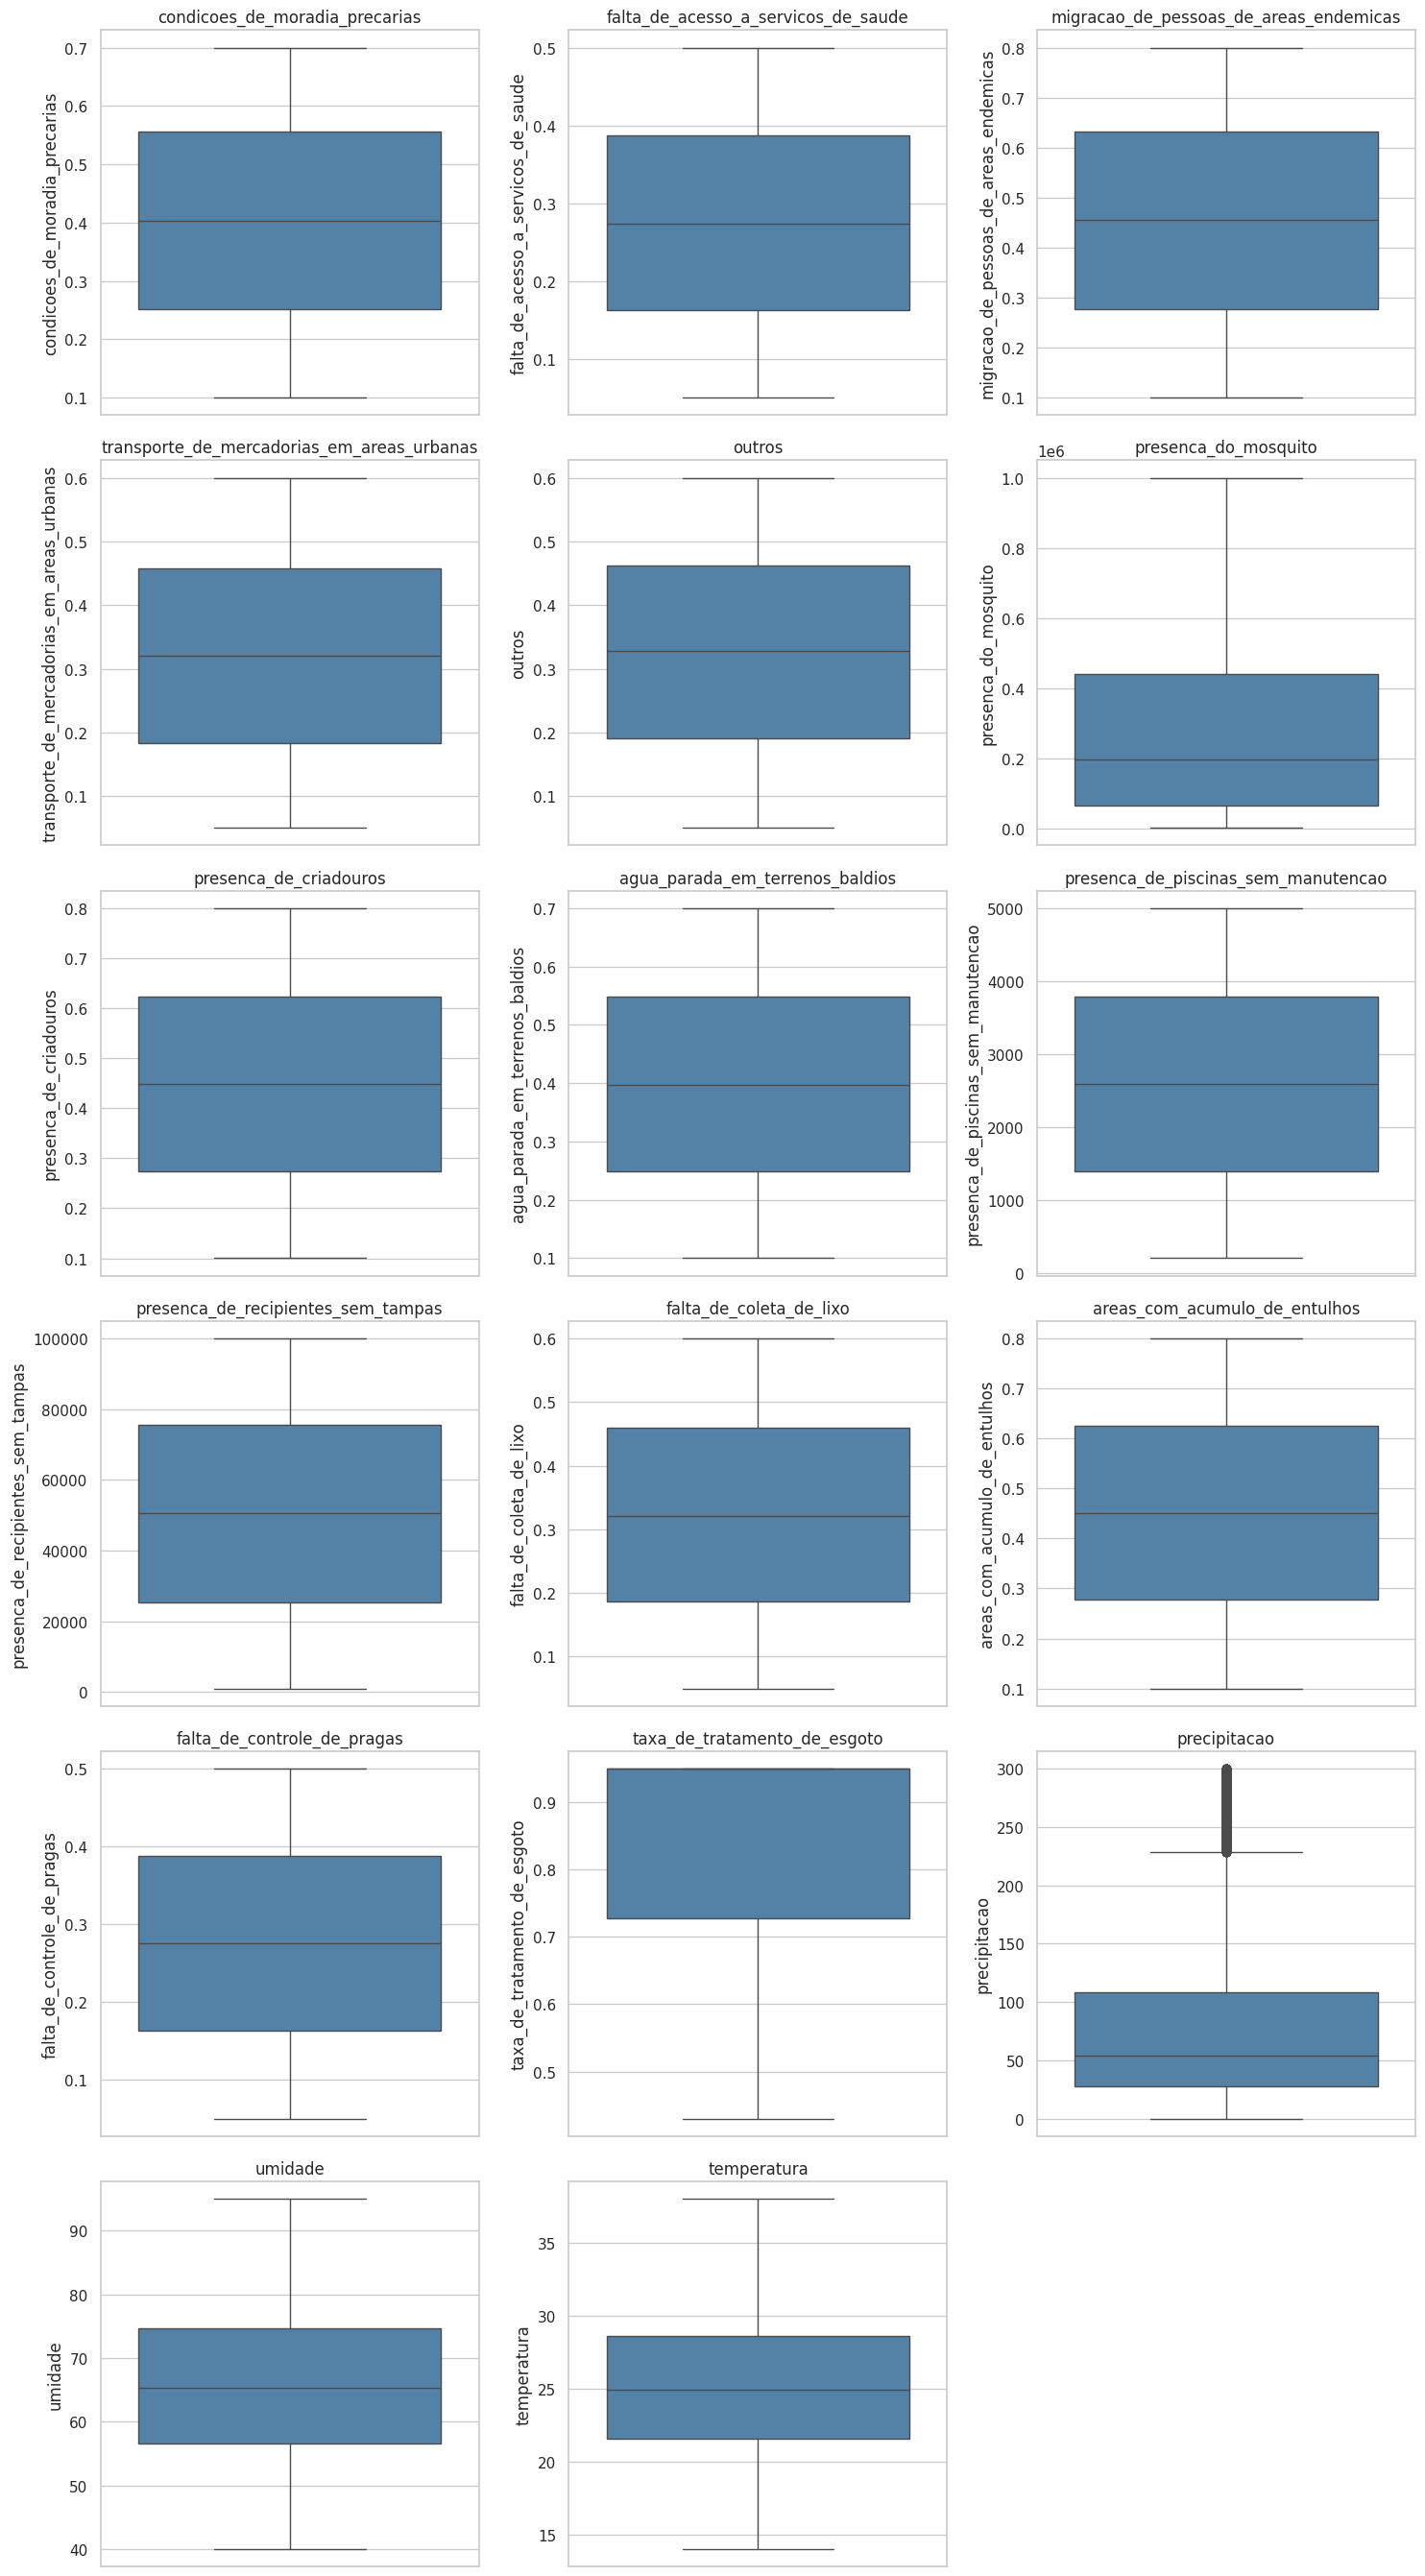

In [32]:
variaveis = df_raw2.columns.tolist()
# Removendo alguns campos da lista de variáveis
variaveis = [var for var in variaveis if var not in ['date', 'casos_de_dengue',
                                                     'status', 'conscientizacao_da_populacao']]

# Verificando se o número de variáveis é ímpar
if len(variaveis) % 2 != 0:
    variaveis.append(None)  # Adiciona um elemento None para garantir um número par de variáveis

# Criando subplots
num = 3
fig, ax = plt.subplots(nrows=len(variaveis)//num, ncols=num, figsize=(15, 3 * (len(variaveis)//2)))

# Iterando sobre as variáveis e criando os boxplots
for i, variavel in enumerate(variaveis):
    if variavel:
        sns.boxplot(y=df_raw2[variavel], ax=ax[i//num, i%num], color="steelblue")
        ax[i//num, i%num].set_title(f'{variavel}')
        ax[i//num, i%num].set_ylabel(variavel)
        ax[i//num, i%num].set_xlabel('')
    else:
        fig.delaxes(ax[i//num, i%num])  # Remove o subplot vazio

# Ajustando layout
plt.tight_layout()

# Exibindo os gráficos
plt.show()

### 3.1.2 Categorical attributes

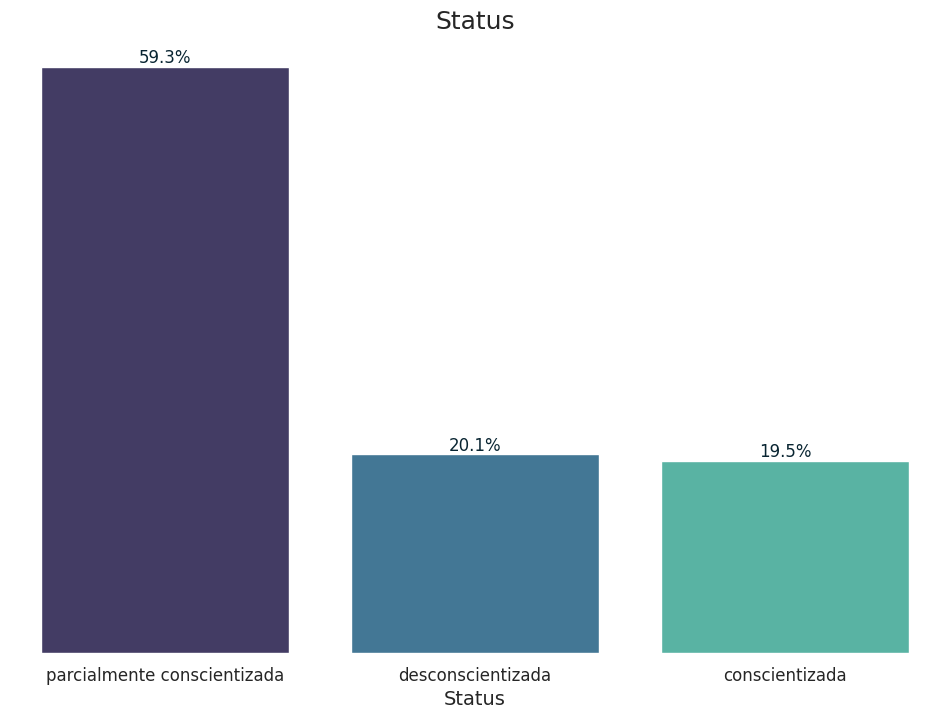

In [33]:
variaveis = df_raw2['status']

# plot com a porcentagem de cada categoria
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='status', data=df_raw2, palette='mako')

# calculando o total de status
total = len(df_raw2['status'])

# add a porcentagem
for bar in ax.patches:
    # calculando a porcentagem
    percentage = '{:.1%}'.format(bar.get_height() / total)
    
    # adicionando a porcentagem ao gráfico
    ax.annotate(percentage,
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=12, xytext=(0, 6),
                    textcoords='offset points',
                    color='#092532')

plt.xlabel('Status', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Status', fontsize=18)
ax.get_yaxis().set_visible(False)
sns.despine(left=True, bottom=True);
plt.show()


## 3.2 Bivariate Analysis

### 3.2.1 Sazonalidade

- Ao analisar os casos de dengue ao longo do tempo, notamos uma certa sazonalidade que pode indicar que em determinados meses do ano os picos de casos podem ser maiores que outros.

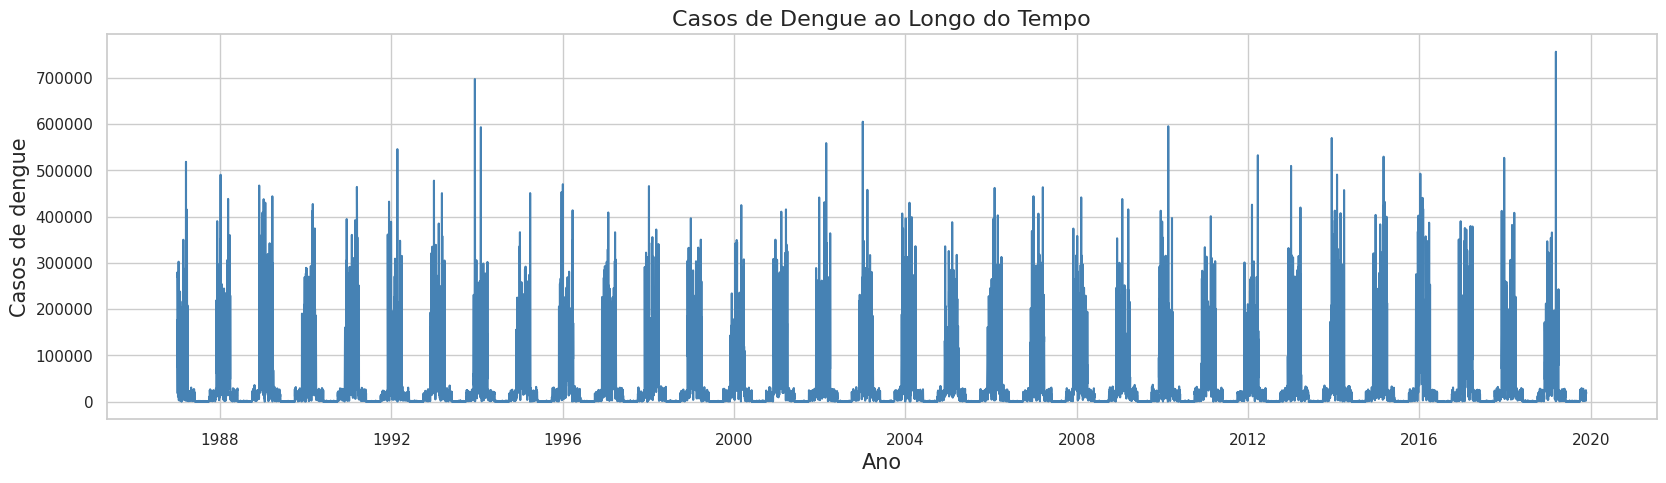

In [34]:
plt.figure(figsize=(20, 5))
aux1 = df_raw2[['date', 'casos_de_dengue']]
aux1.dropna(inplace=True)
aux1['date'] = pd.to_datetime(aux1['date'], format='%Y-%m-%d').dt.normalize()
# Definindo a coluna 'date' como o índice
aux1.set_index('date', inplace=True)

plt.plot(aux1.index, aux1["casos_de_dengue"], color='steelblue')
plt.title('Casos de Dengue ao Longo do Tempo', fontsize=16)
plt.xlabel('Ano', fontsize = 15)
plt.ylabel('Casos de dengue',fontsize = 15)
plt.grid(True)

plt.show()

- Aqui fica mais evidente o aumento dos casos nos meses de dezembro a março, indicando que os casos tendem a subir no verão.

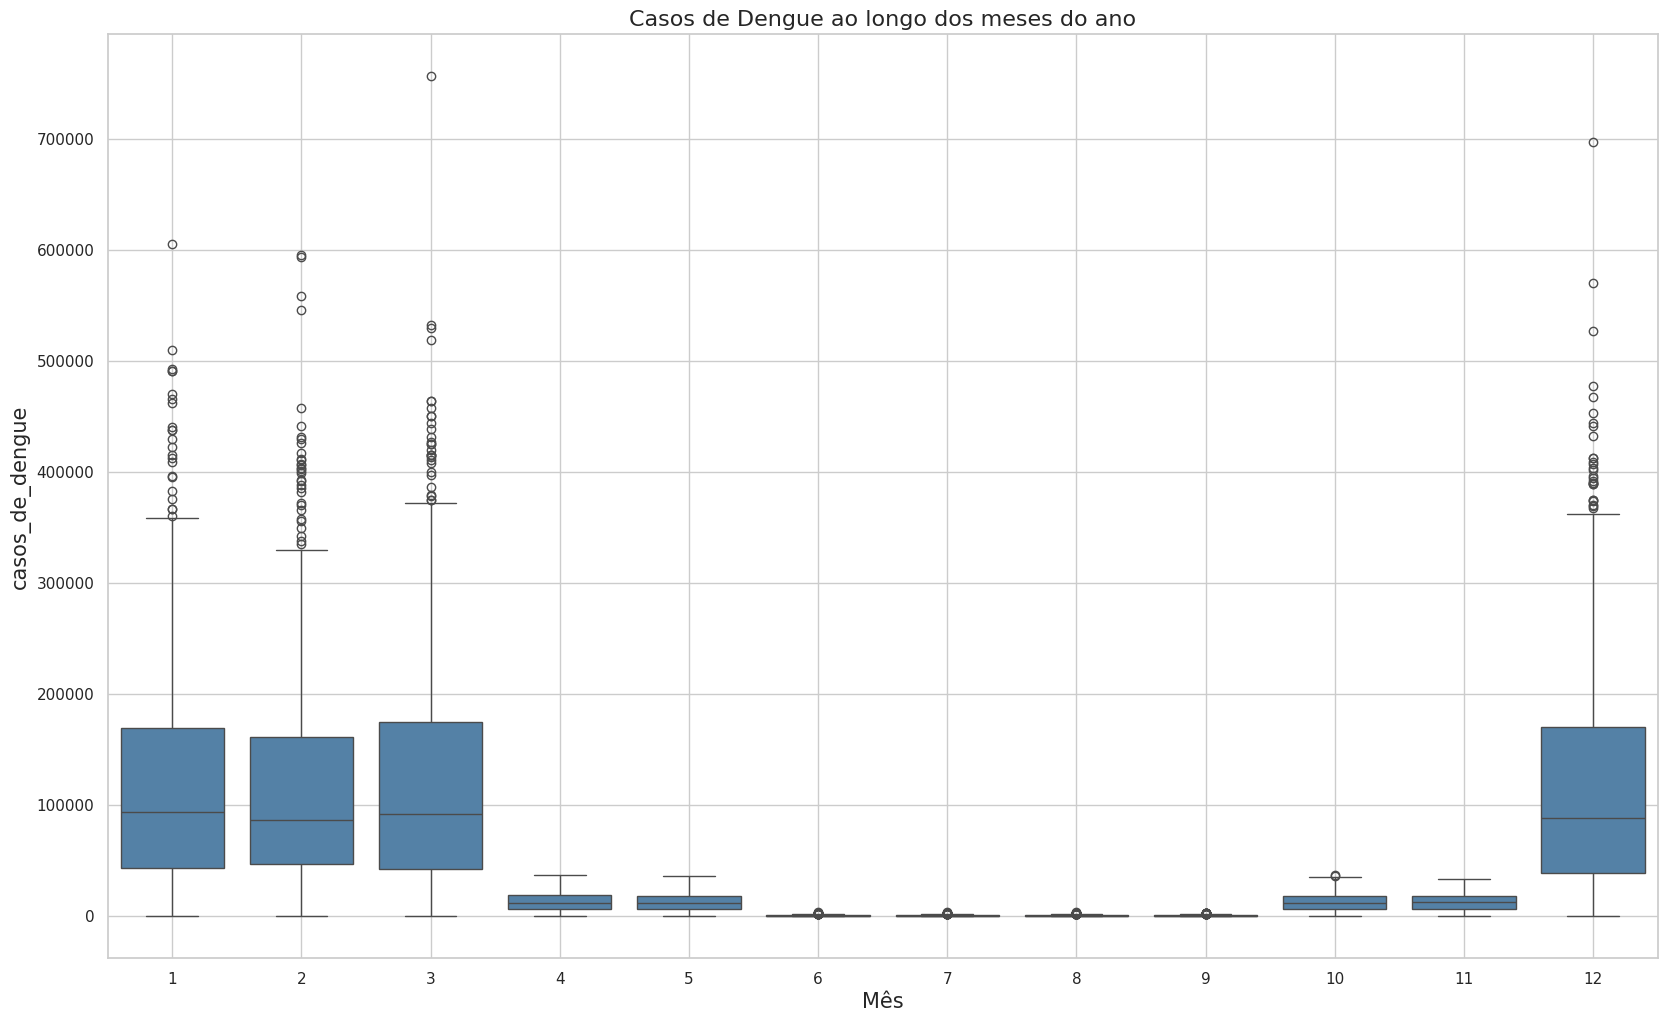

In [35]:
fig, ax = plt.subplots()
aux2 = df_raw2[['date','casos_de_dengue']]
aux2.set_index('date', inplace=True)

sns.boxplot(x=aux2.index.month, y= aux2["casos_de_dengue"], color='steelblue', ax= ax)
plt.title('Casos de Dengue ao longo dos meses do ano', fontsize=16)
plt.xlabel('Mês', fontsize = 15)
plt.ylabel('casos_de_dengue',fontsize = 15)
plt.grid(True)
plt.show()

- Analisando os dados por estações do ano comprovamos que 66% dos casos estao concentrados no verão. 

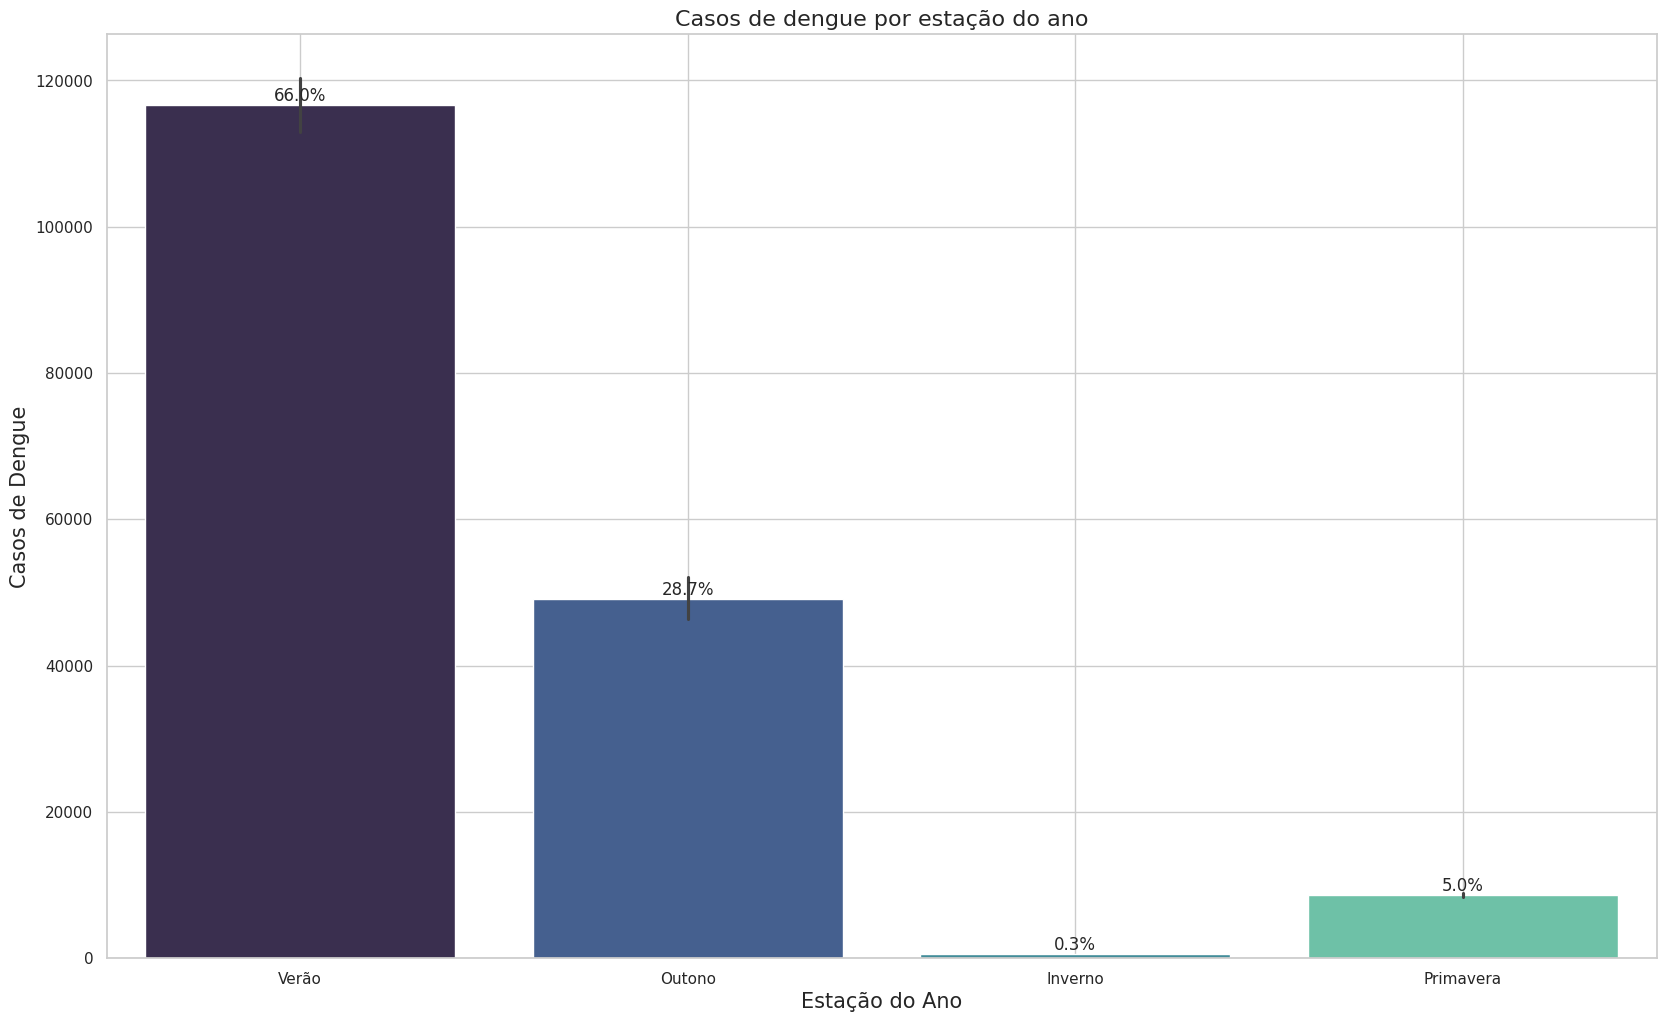

In [36]:
fig, ax = plt.subplots()

# Criando a coluna 'estacao_ano'
df_raw2['estacao_ano'] = df_raw2['date'].dt.month.apply(lambda x: 'Verão' if x in [1,2,12] else 'Outono' if x in [3,4,5] else 'Inverno' if x in [6,7,8] else 'Primavera')

# Criando o DataFrame aux3
aux3 = df_raw2[['estacao_ano','casos_de_dengue']]

# Criando o gráfico de barras
bars = sns.barplot(x='estacao_ano', y='casos_de_dengue', data=aux3, ax=ax, palette='mako')

# Calculando o total de casos de dengue para cada estação do ano
totals = aux3.groupby('estacao_ano')['casos_de_dengue'].sum()

# Calculando o total de casos de dengue
total = aux3['casos_de_dengue'].sum()

# Adicionando a porcentagem acima de cada barra
for i, bar in enumerate(bars.patches):
    # Calculando a porcentagem
    percentage = '{:.1%}'.format(totals[aux3['estacao_ano'].unique()[i]] / total)
    
    # Adicionando a porcentagem ao gráfico
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), percentage, ha='center', va='bottom')

plt.title('Casos de dengue por estação do ano', fontsize=16)
plt.xlabel('Estação do Ano', fontsize = 15)
plt.ylabel('Casos de Dengue',fontsize = 15)
plt.grid(True)
plt.show()

### Clima

- A medida que a umidade, volume de precipitação e temperaturas aumentam, os casos de dengue acompanham a mesma tendência. 
A linha vermelha indica a média dos casos de dengue, podemos constatar visualmente como os dados climáticos influenciam diretamente em nossa variável resposta.

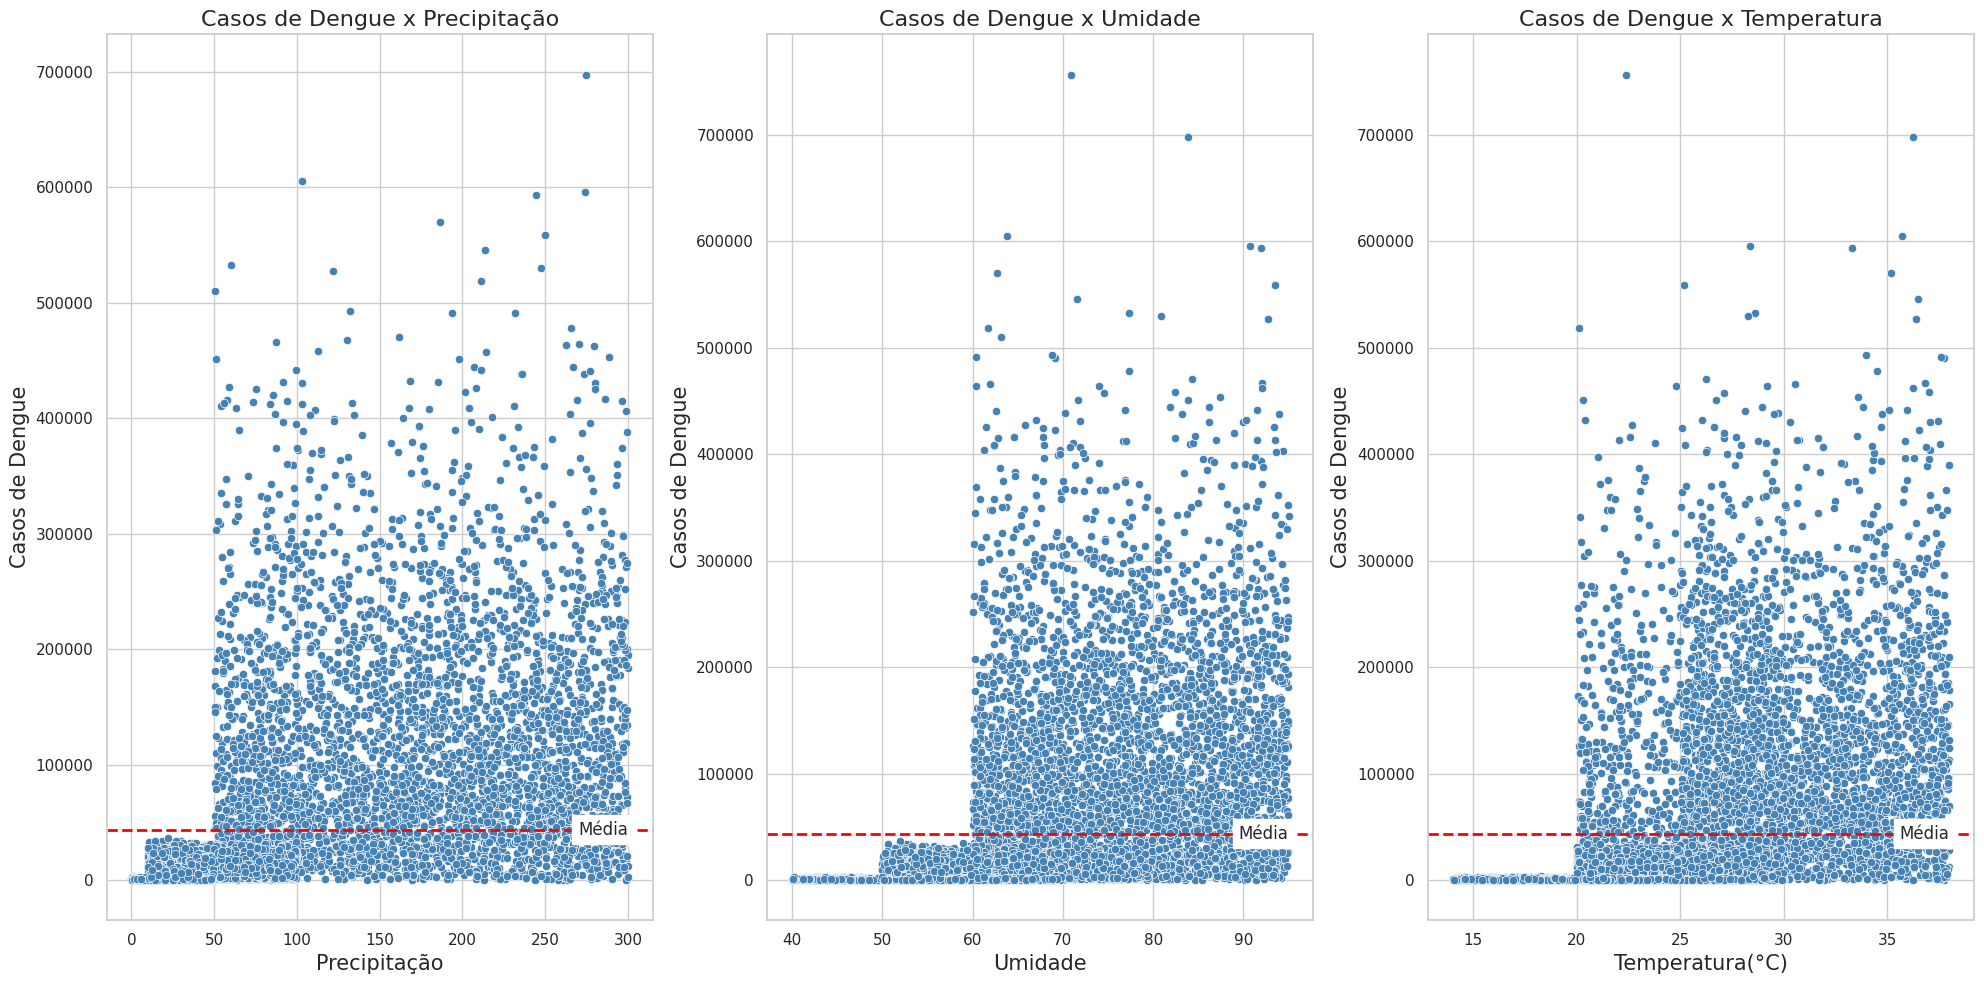

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

# Gráfico de dispersão para precipitação
sns.scatterplot(x='precipitacao', y='casos_de_dengue', data=df_raw2, color='steelblue', ax=ax[0])
mean = df_raw2['casos_de_dengue'].mean()
ax[0].axhline(mean, color='red', linestyle='--', linewidth=2)
ax[0].text(df_raw2['precipitacao'].max(), mean, 'Média', va='center', ha='right', backgroundcolor='w')
ax[0].set_title('Casos de Dengue x Precipitação', fontsize=16)
ax[0].set_xlabel('Precipitação', fontsize=15)
ax[0].set_ylabel('Casos de Dengue', fontsize=15)

# Gráfico de dispersão para umidade
sns.scatterplot(x='umidade', y='casos_de_dengue', data=df_raw2, color='steelblue', ax=ax[1])
ax[1].axhline(mean, color='red', linestyle='--', linewidth=2)
ax[1].text(df_raw2['umidade'].max(), mean, 'Média', va='center', ha='right', backgroundcolor='w')
ax[1].set_title('Casos de Dengue x Umidade', fontsize=16)
ax[1].set_xlabel('Umidade', fontsize=15)
ax[1].set_ylabel('Casos de Dengue', fontsize=15)

# Gráfico de dispersão para temperatura
sns.scatterplot(x='temperatura', y='casos_de_dengue', data=df_raw2, color='steelblue', ax=ax[2])
ax[2].axhline(mean, color='red', linestyle='--', linewidth=2)
ax[2].text(df_raw2['temperatura'].max(), mean, 'Média', va='center', ha='right', backgroundcolor='w')
ax[2].set_title('Casos de Dengue x Temperatura', fontsize=16)
ax[2].set_xlabel('Temperatura(°C)', fontsize=15)
ax[2].set_ylabel('Casos de Dengue', fontsize=15)

plt.tight_layout()
plt.show()

### Presença de mosquito

- Traçamos uma reta de regressão para representar a relação entre as duas variáveis. Podemos notar que a reta é ascendente o que indica uma relação positiva, ou seja, a medida que a presença do mosquito aumenta, os casos de dengue também aumentam.

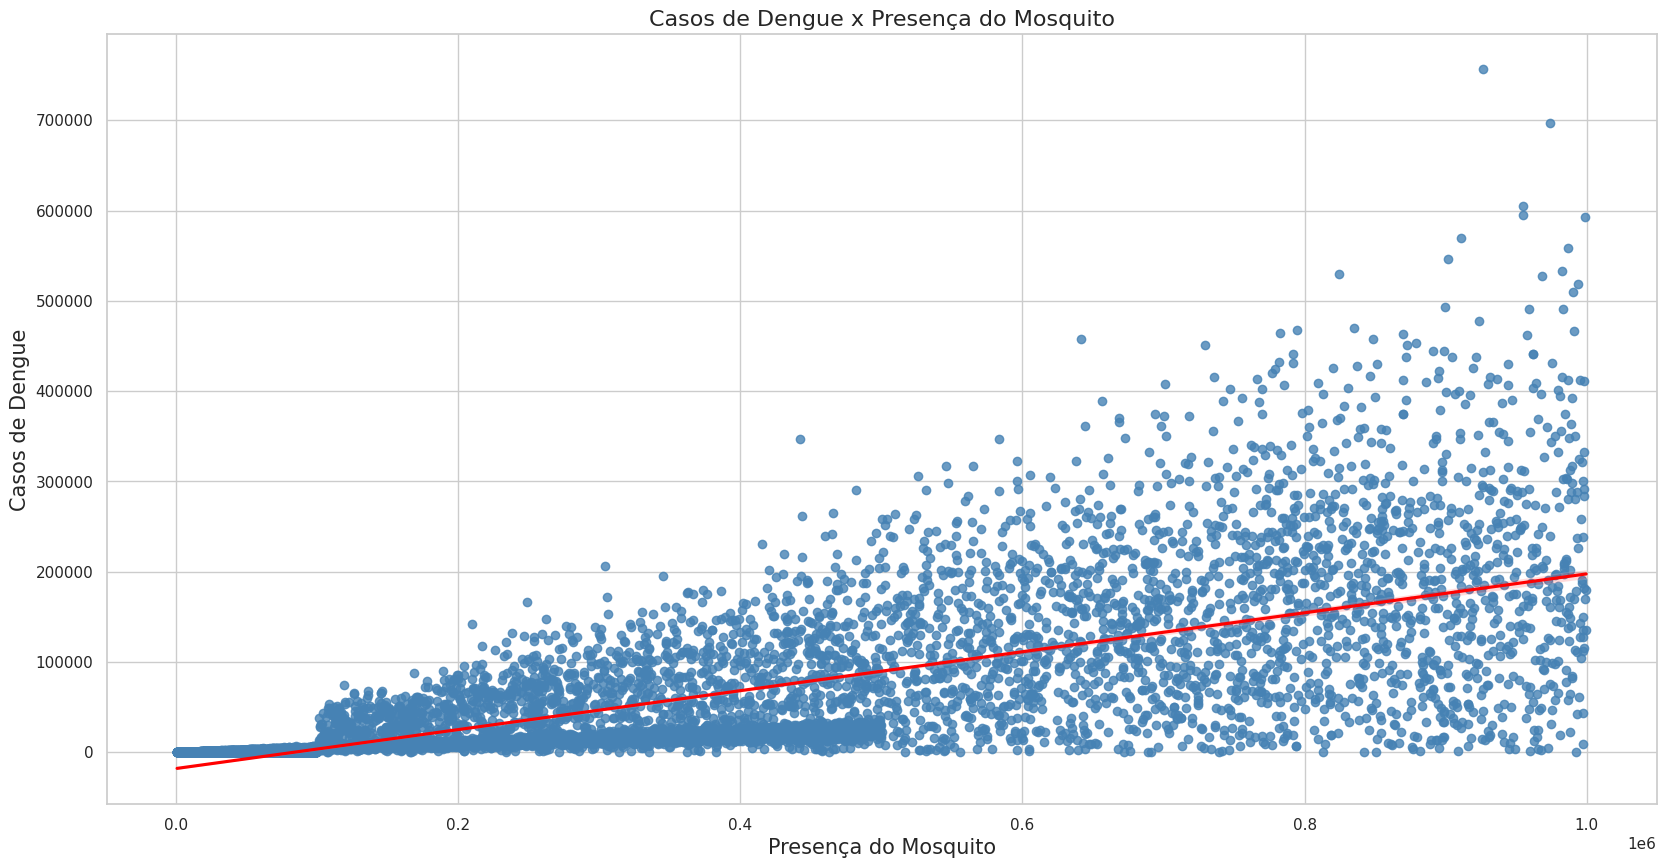

In [38]:
plt.figure(figsize=(20, 10))

sns.regplot(x='presenca_do_mosquito', y='casos_de_dengue', data=df_raw2, color='steelblue', line_kws={'color': 'red'})
plt.title('Casos de Dengue x Presença do Mosquito', fontsize=16)
plt.xlabel('Presença do Mosquito', fontsize=15)
plt.ylabel('Casos de Dengue', fontsize=15)
plt.grid(True)
plt.show()

## 3.3 Multivariate analysis

- Analisando o heatmap, podemos observar uma correlação moderadamente forte e positiva entre os casos de dengue e as variáveis de precipitação (0,74), umidade (0,63) e temperatura (0,61). Isso sugere que o aumento nos casos de dengue está associado a essas três variáveis. Além disso, nota-se que a temperatura apresenta uma correlação moderadamente positiva com a precipitação (0,56) e a umidade (0,48). Essa relação sugere uma tendência de aumento na precipitação e umidade conforme a temperatura aumenta. Por exemplo, em um estudo climático, essa correlação pode ser explicada pelo aumento da evaporação da água à medida que a temperatura sobe, resultando em maior formação de nuvens e consequentemente mais precipitação.

- O que fica evidente é como a variável presenca_de_mosquito é altamente correlacionada com nossa variável resposta. Essa correlação não significa que os mosquitos sejam a única causa dos casos de dengue. Outros fatores, como condições climáticas, saneamento básico, hábitos de higiene e medidas de controle de vetor, também desempenham papéis importantes na propagação da doença.

- Variáveis com alta correlação podem fazer com que o modelo fique muito dependente e não seja capaz de generalizar em dados que ele nunca viu. Outro risco é um potencial viés, podendo o modelo ir em direção somente dessa variável, ignorando outros fatores importantes que influenciam no resultado como já mencionado anteriormente.

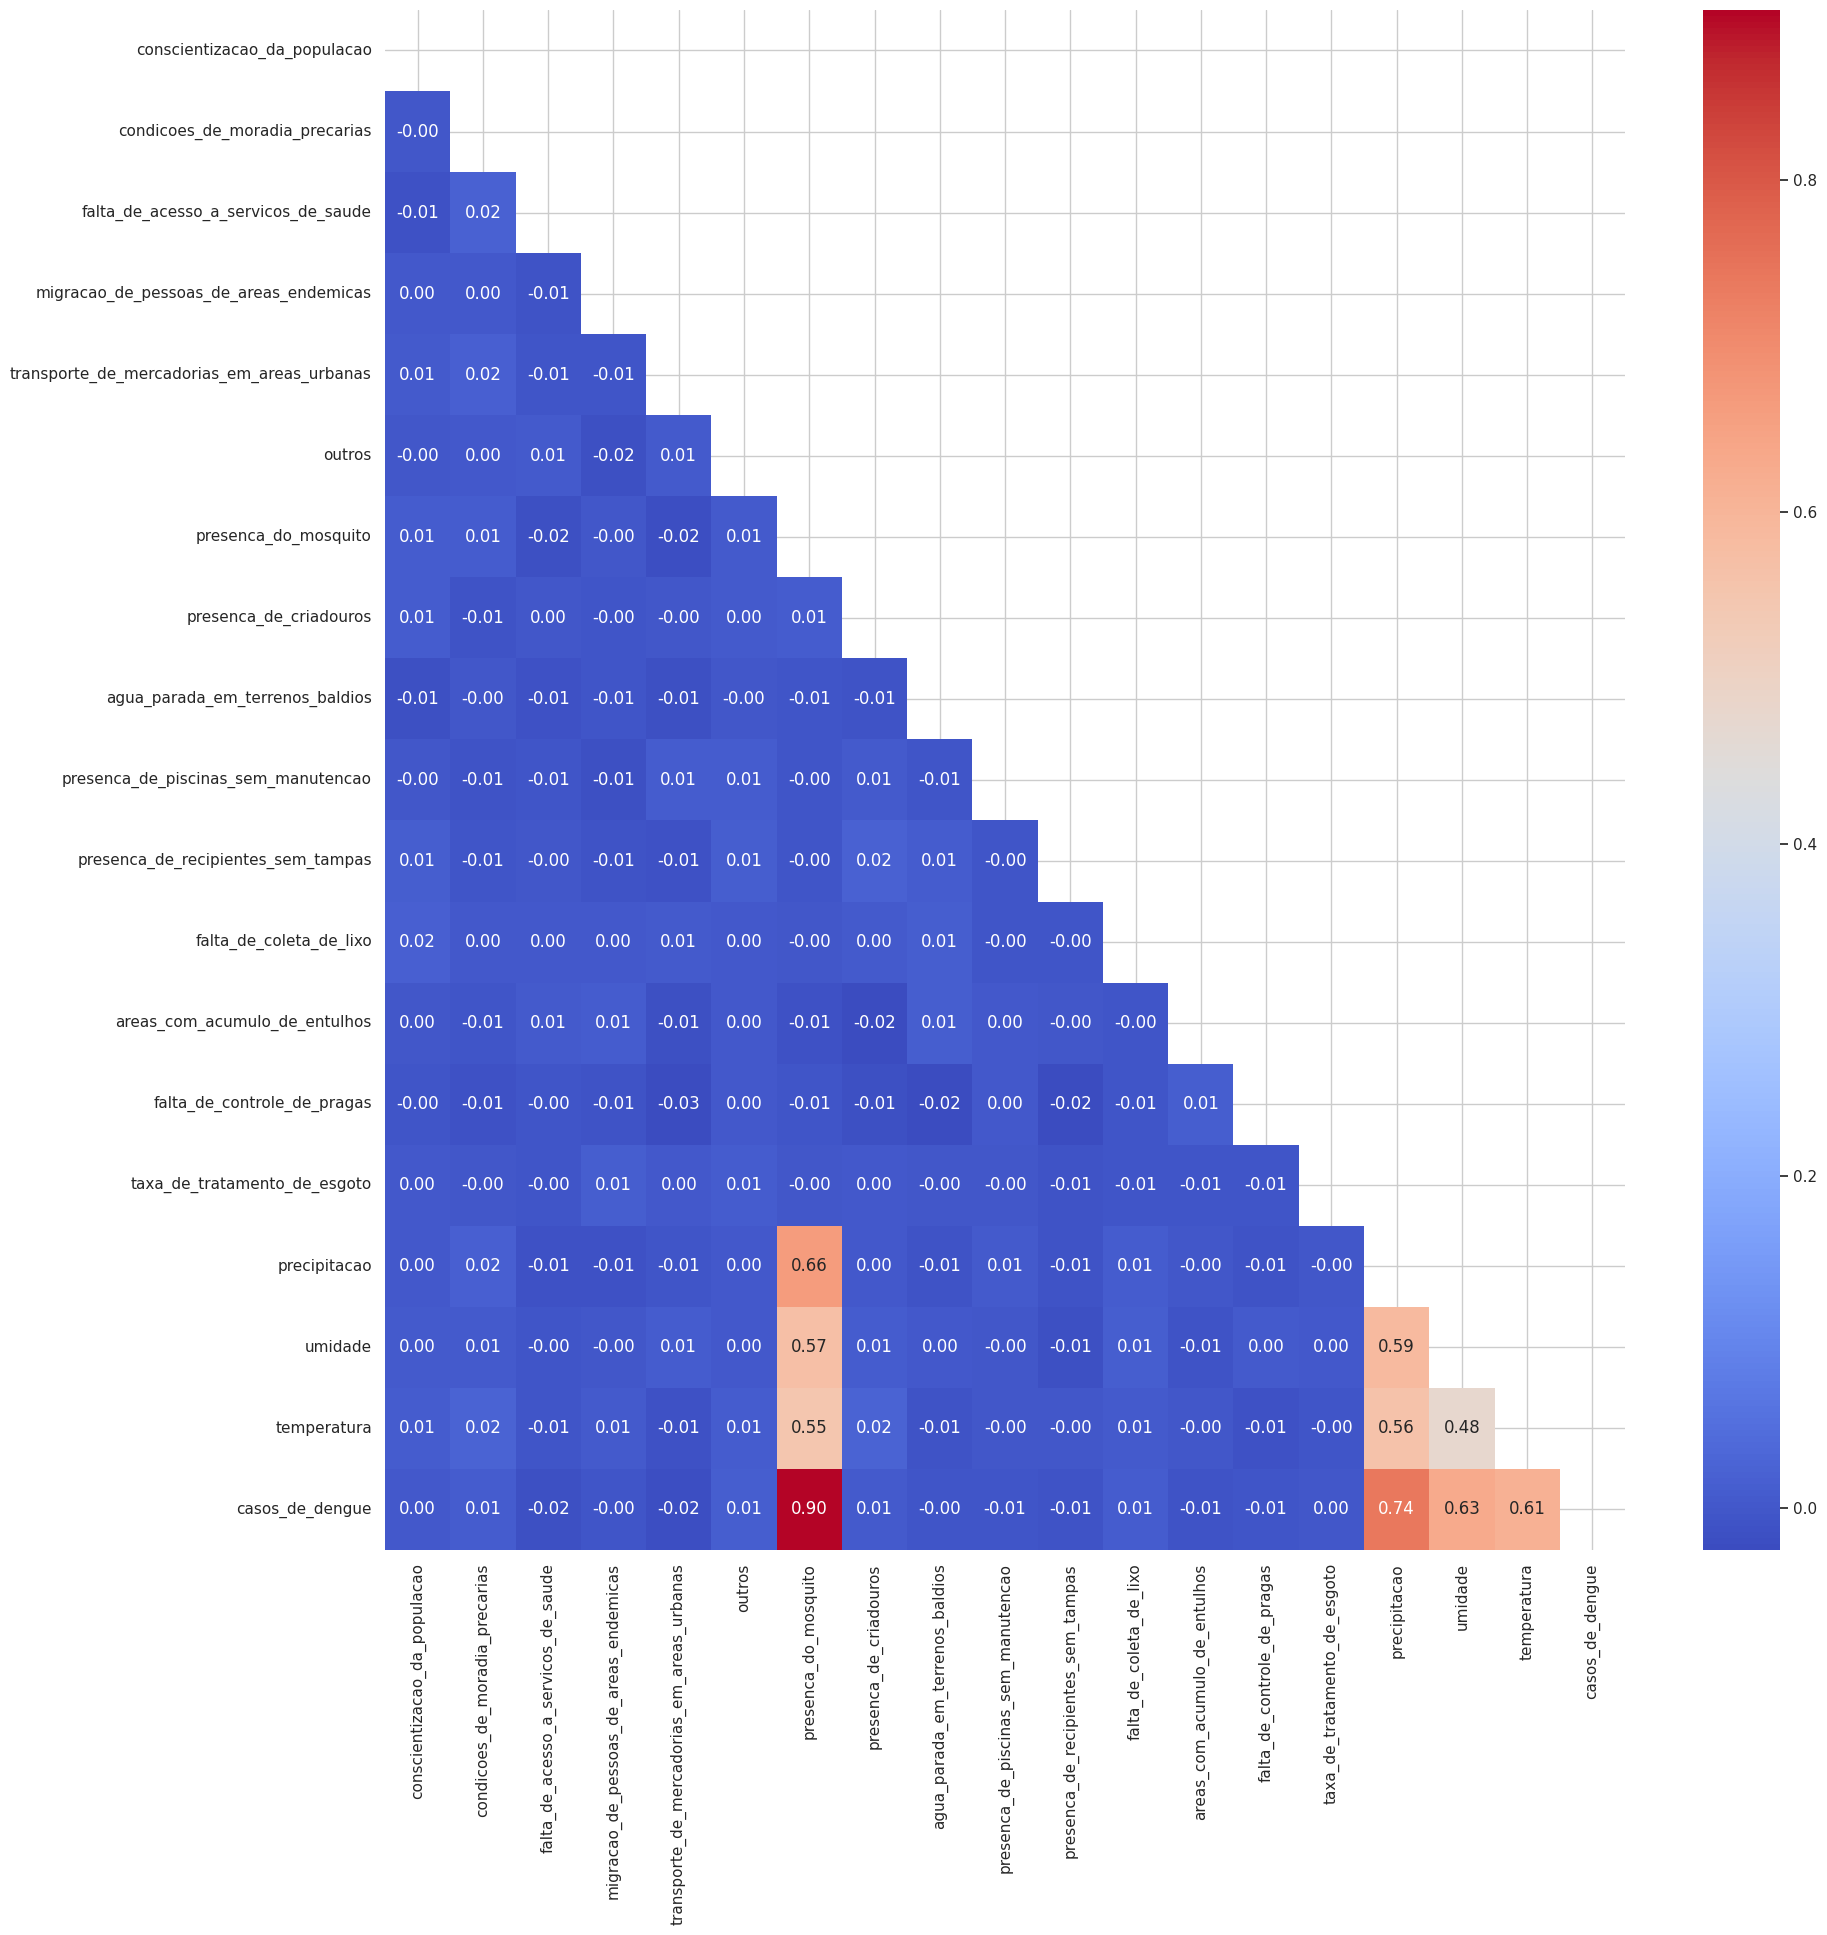

In [39]:
#criar correlação
correlation = num_attributes.corr(method='spearman')
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.show()

# 4.0 Data Filtering

In [40]:
df4 = df3.copy()

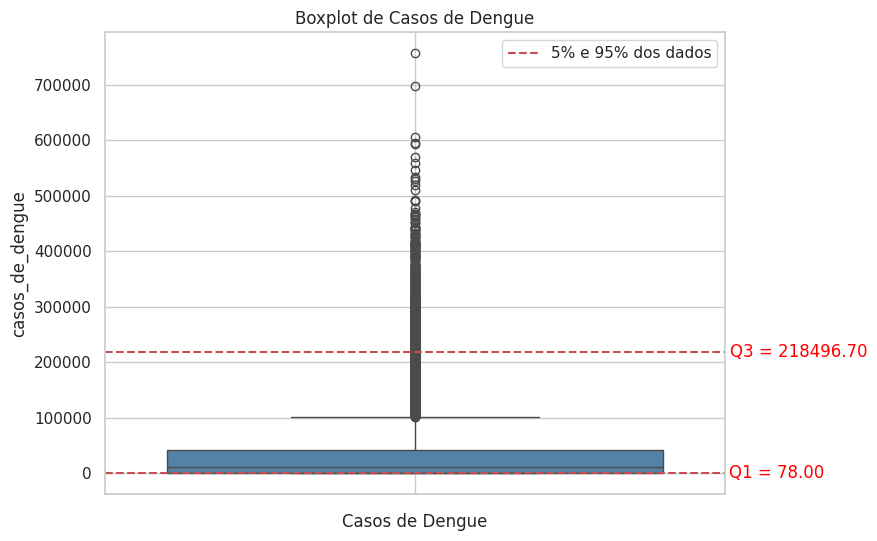

In [41]:
# Criando o boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_raw2["casos_de_dengue"], color='steelblue')

# Calculando os limites de 5% e 95% dos dados
q1, q3 = np.percentile(df_raw2["casos_de_dengue"], [5, 95])

# Adicionando a linha indicando 90% dos dados
plt.axhline(y=q1, color='r', linestyle='--', label='5% e 95% dos dados')
plt.axhline(y=q3, color='r', linestyle='--')

# Adicionando Q1 e Q3 no gráfico
plt.text(0.66, q1, f'Q1 = {q1:.2f}', verticalalignment='center', horizontalalignment='right', color='red')
plt.text(0.73, q3, f'Q3 = {q3:.2f}', verticalalignment='center', horizontalalignment='right', color='red')

# Adicionando títulos e rótulos
plt.title('Boxplot de Casos de Dengue')  # Título do gráfico
plt.xlabel('Casos de Dengue')  # Rótulo do eixo x
plt.grid(True)  # Ativa a grade

# Exibindo o gráfico
plt.legend()  # Mostra a legenda
plt.show()

In [42]:
percentil_95 = df4['casos_de_dengue'].quantile(0.95)
print('95% percentil da variavel target:', percentil_95)

95% percentil da variavel target: 218496.70000000007


- Como ja identificamos na etapa de análise exploratória, nossa variável target contém muitos outliers. Aqui filtramos nosso dataset para que fosse selecionado apenas valores com no máximo 217000 casos, ligeiramente abaixo do quartil 95%. Reconhecemos que esses valores extremos têm o potencial de distorcer a interpretação dos resultados. Não estamos sugerindo que esses valores sejam incorretos, mas sim que representam comportamentos atípicos que podem impactar diretamente os resultados do nosso modelo.

In [43]:
rows_before = df3.shape[0]
df4 = df4.loc[df4['casos_de_dengue'] < 217000]
rows_after = df4.shape[0]

removed_rows = rows_before - rows_after
removed_percentage = (removed_rows / rows_before) * 100

print('Linhas removidas: {}'.format(removed_rows))
print('Porcentagem de dados removidos: {:.2f}%'.format(removed_percentage))

Linhas removidas: 608
Porcentagem de dados removidos: 5.06%


# 5.0 Data Preparation

In [44]:
df5 = df4.copy()
test = data_clean(df_test, is_train=False)
test = fill_na(test)
test = feature_engineering(test)



### 5.1 Feature Selection

In [45]:
TARGET = ['casos_de_dengue']

SELECTED_FEATURES = [#'date',
                    'conscientizacao_da_populacao',
                    'condicoes_de_moradia_precarias',
                    'falta_de_acesso_a_servicos_de_saude',
                    'migracao_de_pessoas_de_areas_endemicas',
                    'transporte_de_mercadorias_em_areas_urbanas',
                    'outros',
                    #'presenca_do_mosquito',
                    'status',
                    'presenca_de_criadouros',
                    'agua_parada_em_terrenos_baldios',
                    'presenca_de_piscinas_sem_manutencao',
                    'presenca_de_recipientes_sem_tampas',
                    'falta_de_coleta_de_lixo',
                    'areas_com_acumulo_de_entulhos',
                    'falta_de_controle_de_pragas',
                    #'taxa_de_tratamento_de_esgoto',
                    #'precipitacao',
                    #'umidade',
                    #'temperatura',
                    #'pca_clima',
                    'estacao_ano',
                    'semana_ano',
                    'ano',
                    'mes',
                    'dia'
                    #'itu'
]


y = df5[TARGET]
X = df5[SELECTED_FEATURES]
X_test = test[SELECTED_FEATURES]

### 5.2 Encoding

- Transformar dados categóricos em numéricos

In [46]:
def enconding(df):
    df['status'] = df['status'].apply(lambda x: 1 if x == 'desconscientizada' else 2 if x == 'parcialmente conscientizada' else 3)
    # one hot encoding para estacao do ano
    df = pd.get_dummies(df, columns=['estacao_ano'], drop_first=True)

    return df

In [47]:
X = enconding(X)
X_test = enconding(X_test)

### 5.3 Evaluation Metric

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

\begin{align*}
\text{Legenda:} \\
- \, n & : \text{ número total de observações.} \\
- \, y_i & : \text{ valores reais.} \\
- \, \hat{y}_i & : \text{ valores previstos pelo modelo.}
\end{align*}


In [48]:
# funcao para calcular rmse
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# 6.0 Model

### 6.1 Baseline

- Utilizamos a média de todos os valores como baseline para comparação.


In [49]:
# crie um baseline utilizando a media dos dados
baseline = np.repeat(y.mean(), len(y))

# calcule o rmse
baseline_rmse = rmse(y, baseline)
print('Baseline RMSE: {:.4f}'.format(baseline_rmse))

Baseline RMSE: 48200.8084


### 6.2 LGBM Regressor

In [50]:
RANDOM_SEED = 42

def objective(trial):

    param_grid = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 50), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500), 
        'seed': RANDOM_SEED,
        'verbose': -1
    }

    model = LGBMRegressor(**param_grid)

    number_folds = 5
    kfold = KFold(n_splits=number_folds, shuffle=False)

    y_pred = cross_val_predict(model, X, y, cv=kfold)


    return rmse(y, y_pred)



In [51]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=150)
trial = study.best_trial

[I 2024-05-11 19:08:37,295] A new study created in memory with name: regression
[I 2024-05-11 19:08:38,111] Trial 0 finished with value: 34704.21117102976 and parameters: {'num_leaves': 23, 'n_estimators': 375, 'learning_rate': 0.0027355726481525684, 'max_depth': 9, 'min_child_samples': 86}. Best is trial 0 with value: 34704.21117102976.
[I 2024-05-11 19:08:38,320] Trial 1 finished with value: 37422.99348237594 and parameters: {'num_leaves': 35, 'n_estimators': 100, 'learning_rate': 0.006259640073204871, 'max_depth': 9, 'min_child_samples': 421}. Best is trial 0 with value: 34704.21117102976.
[I 2024-05-11 19:08:38,650] Trial 2 finished with value: 34166.77350393665 and parameters: {'num_leaves': 25, 'n_estimators': 199, 'learning_rate': 0.005651654998225648, 'max_depth': 6, 'min_child_samples': 457}. Best is trial 2 with value: 34166.77350393665.
[I 2024-05-11 19:08:39,026] Trial 3 finished with value: 32400.09230834929 and parameters: {'num_leaves': 14, 'n_estimators': 229, 'learning

In [52]:
# Print the result
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 32163.4609204825

Optimized parameters: {'num_leaves': 28, 'n_estimators': 466, 'learning_rate': 0.007684684460410053, 'max_depth': 4, 'min_child_samples': 500}



In [53]:
def CVResults(model, X, y):

    number_folds = 5
    Kfold = KFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED)

    rmse_score = make_scorer(rmse)
    scores = cross_validate(model, X, y, cv=Kfold, scoring=rmse_score, return_train_score=True)
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    y_pred = np.expm1(y_pred)

    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])
    rmse_avg = df.loc['test_score', 'value']

    return rmse_avg, y_pred

In [54]:
lgbm = LGBMRegressor(**lgbm_best_params, verbose=-1, random_state=RANDOM_SEED)
lgbm.fit(X,y)
lgbm_rmse ,lgbm_pred = CVResults(lgbm, X, y)

,value,std
fit_time,0.0900,0.0015
score_time,0.0051,0.0002
test_score,"32,169.0867",937.0592
train_score,"31,800.8132",227.2375


In [55]:
print('LGBM RMSE: {:.4f}'.format(lgbm_rmse))
print('Baseline RMSE: {:.4f}'.format(baseline_rmse))
improvement = ((baseline_rmse - lgbm_rmse) / baseline_rmse) * 100
print('Percentagem de melhoria: {:.2f}%'.format(improvement))


LGBM RMSE: 32169.0867
Baseline RMSE: 48200.8084
Percentagem de melhoria: 33.26%


# 7.0 Teste

In [56]:
lgbm.fit(X, y)
y_test_lgbm = lgbm.predict(X_test)
y_test_lgbm

array([12888.14936246, 12992.55161104, 12868.62979728, ...,
       84240.01038054, 84240.01038054, 84240.01038054])

In [57]:
test['Casos de dengue'] = y_test_lgbm
test['Casos de dengue'] = test['Casos de dengue'].astype(int)

In [58]:
# renomear coluna date
test.rename(columns={'date':'Date'},inplace=True)

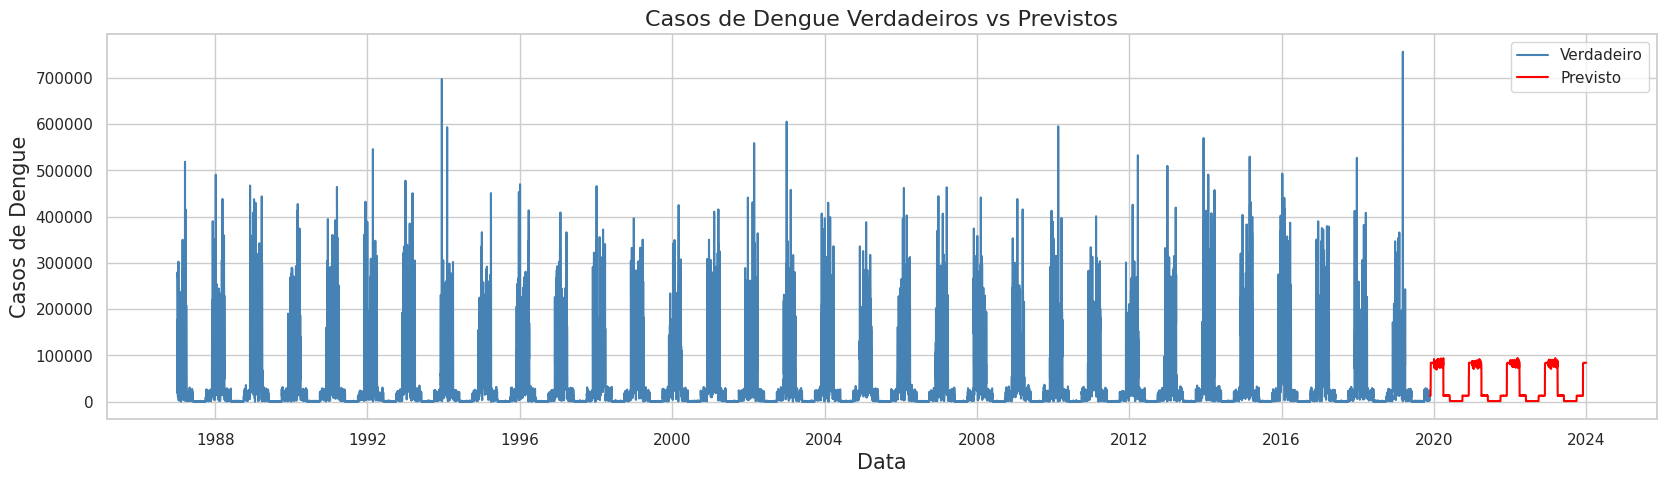

In [59]:
#plotar casos de dengue verdadeiros e previstos
plt.figure(figsize=(20, 5))
plt.plot(df_raw2['date'], df_raw2['casos_de_dengue'], label='Verdadeiro', color='steelblue')
plt.plot(test['Date'], test['Casos de dengue'], label='Previsto', color='red')
plt.title('Casos de Dengue Verdadeiros vs Previstos', fontsize=16)
plt.xlabel('Data', fontsize=15)
plt.ylabel('Casos de Dengue', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()


## 8.0 Submission

In [60]:
# test[['Date','Casos de dengue']].to_csv("submission_27.csv", index=False)